In [6]:
import pandas as pd
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model_name = "codesage/codesage-small" #"BAAI/bge-small-en"
model_kwargs = {"device": "cpu", "trust_remote_code":True}
encode_kwargs = {"normalize_embeddings": True}
bge_embed = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

c:\Users\arash\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No sentence-transformers model found with name codesage/codesage-small. Creating a new one with MEAN pooling.


In [7]:
df = pd.read_csv('train.csv')
df.head()
len(df)

108971

In [154]:
texts = df['text'].to_numpy()

In [155]:
texts = np.random.choice(texts, 10000, replace=False)
embeddings = np.array([bge_embed.embed_query(text) for text in texts])
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)
# Plot


In [158]:
np.savez('sample_verilog_10000_code_sage_small.npz', texts=texts, code_sage_small=embeddings, tsne=tsne_results)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


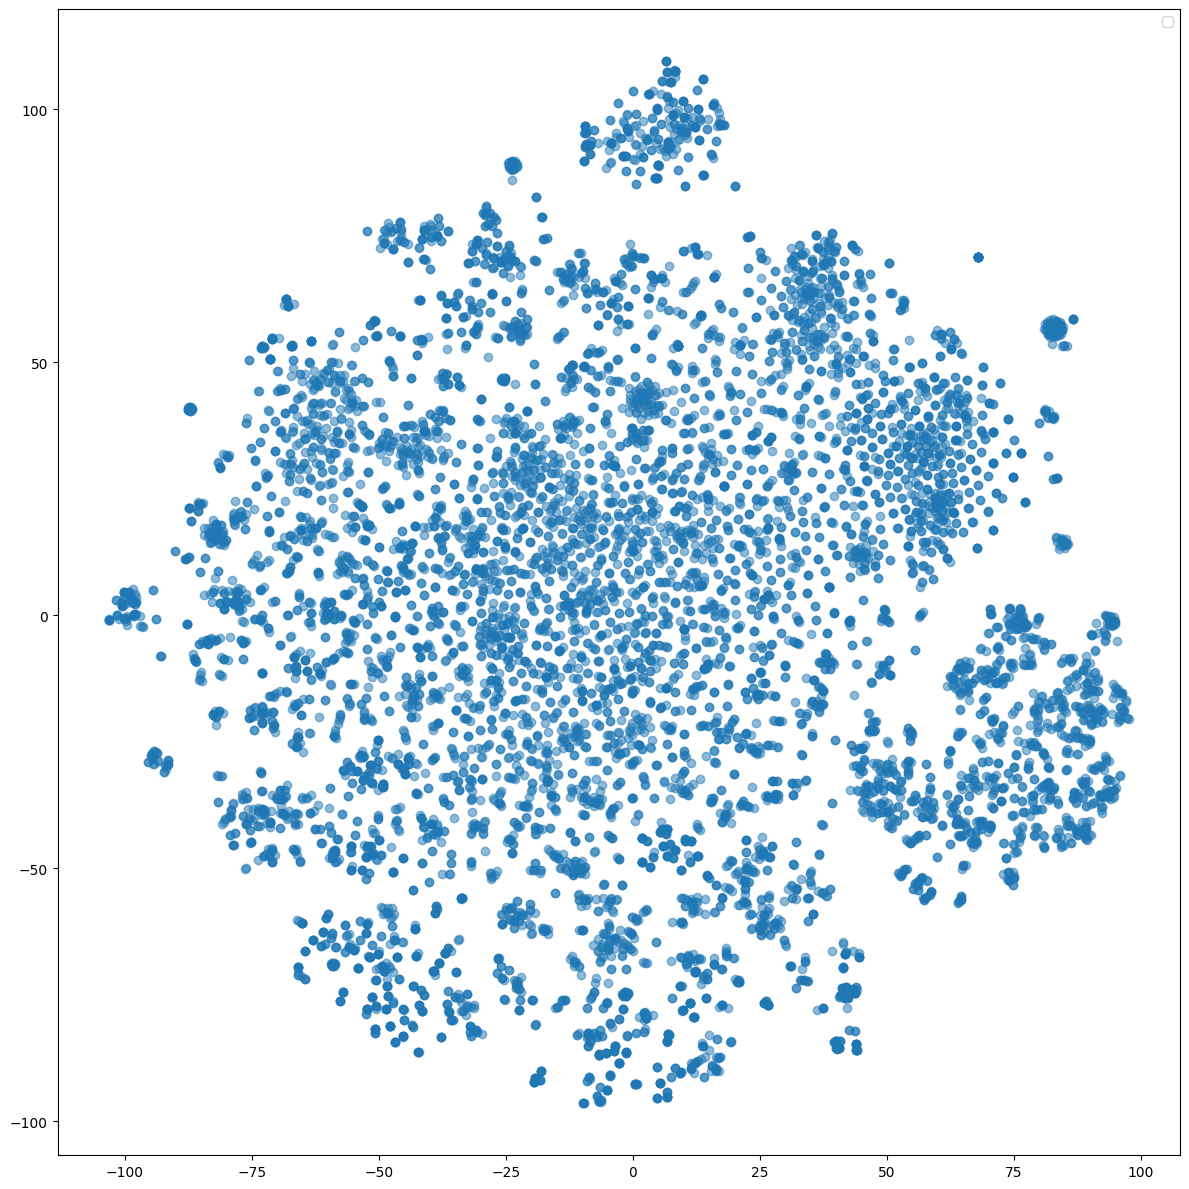

In [157]:
fig = plt.subplots(figsize=(12, 12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## PCA 
We look at how many components we need to explain the variance in data

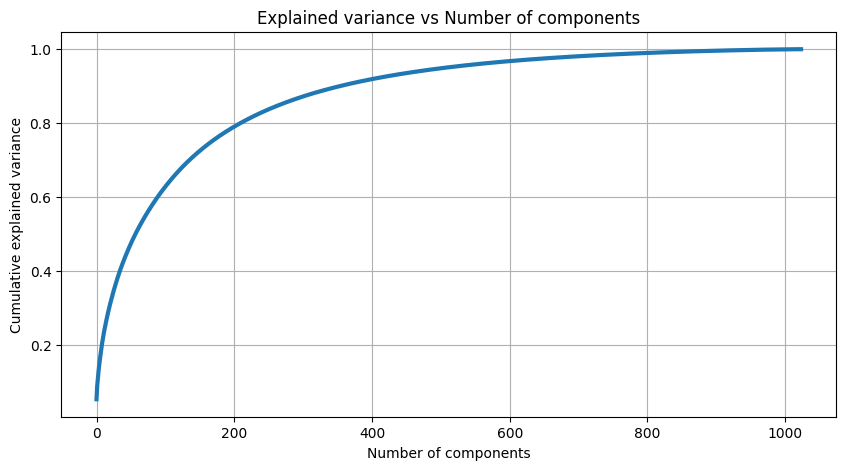

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

with np.load('sample_verilog_10000_code_sage_small.npz', allow_pickle=True) as data:
    embeddings = data['code_sage_small']

# Running PCA from 1 to n components
pca = PCA(n_components=embeddings.shape[1])
pca.fit(embeddings)

# The amount of variance that each PC explains
variance = pca.explained_variance_ratio_

# The cumulative variance explained by the PCs
cumulative_variance = np.cumsum(variance)

# Plotting the cumulative variance against the number of components
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, lw=3)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs Number of components')
plt.grid(True)
plt.show()


There is no elbow in the data which suggests that we should probably keep everything and we should not reduce the number of components before performing any clustering.

## Clustering

We attempt to perform (unsupervised) clustering of our datapoints. We further dig into the clusters to see what we find.

In [162]:
import numpy as np

with np.load('sample_verilog_10000_code_sage_small.npz', allow_pickle=True) as data:
    embeddings = data['code_sage_small']

Silhouette Score for k=2: 0.037653133212259056
Silhouette Score for k=3: 0.047878945245681134
Silhouette Score for k=4: 0.035826510837373135
Silhouette Score for k=5: 0.03991075913181175
Silhouette Score for k=6: 0.041947772018786876
Silhouette Score for k=7: 0.03945066906821953
Silhouette Score for k=8: 0.03756455093054344
Silhouette Score for k=9: 0.040736366971721547
Silhouette Score for k=10: 0.04467095753872493
Silhouette Score for k=11: 0.046504815350903984
Silhouette Score for k=12: 0.04804579248621905
Silhouette Score for k=13: 0.037089961494653184
Silhouette Score for k=14: 0.03807781858688472
Silhouette Score for k=15: 0.03889275101963622
Silhouette Score for k=16: 0.03975194676229686
Silhouette Score for k=17: 0.038912191691333746
Silhouette Score for k=18: 0.04192036219143974
Silhouette Score for k=19: 0.04190461110970232
Silhouette Score for k=20: 0.04307513461784718
Silhouette Score for k=21: 0.0467509788995528
Silhouette Score for k=22: 0.04688110885414055
Silhouette Sco

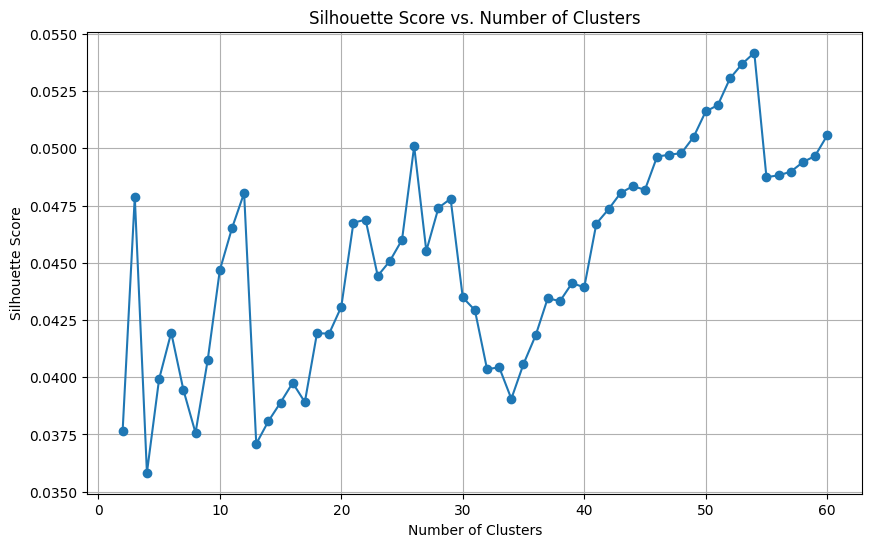

In [163]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'embeddings' is your dataset
embeddings_normalized = normalize(embeddings)

# Range of number of clusters
n_clusters = range(2, 61)  # Silhouette score cannot be computed with only one cluster

silhouette_scores = []

for k in n_clusters:
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_normalized)
    
    # Compute the silhouette score and append it to the list
    score = silhouette_score(embeddings_normalized, cluster_labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score}")

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

c:\Users\arash\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


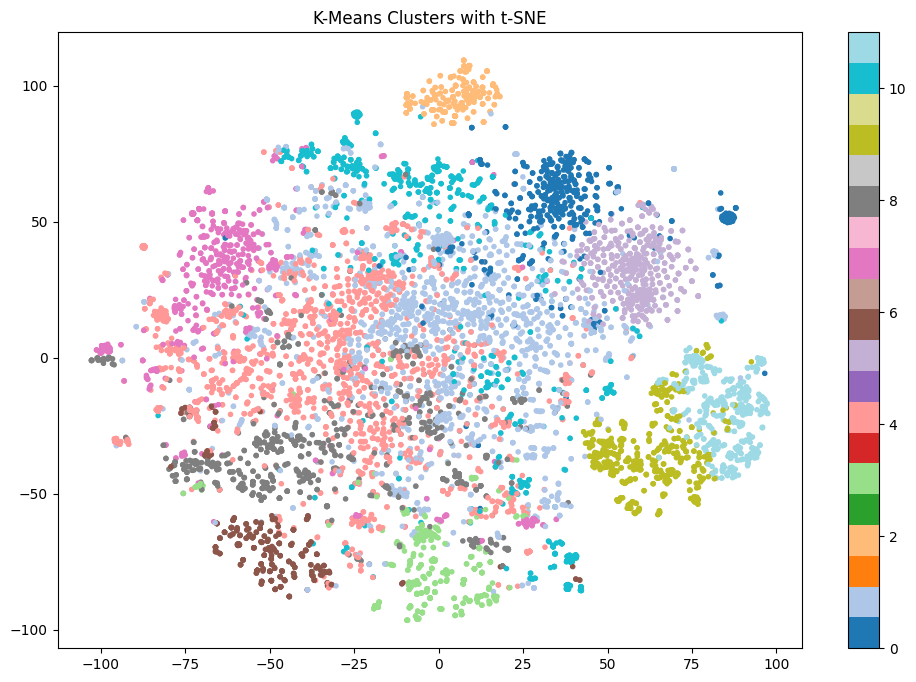

In [164]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'embeddings' is your dataset with text data represented in high-dimensional space

# Normalize the embeddings to unit length, which makes the KMeans clustering similar to using cosine similarity
embeddings_normalized = normalize(embeddings)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=12, random_state=42)  # You can choose a number of clusters suited for your dataset
kmeans.fit(embeddings_normalized)
labels = kmeans.labels_

# Reduce dimensions to 2D using t-SNE for visualization purposes
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_normalized)

# Plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='tab20', marker='.')
plt.title('K-Means Clusters with t-SNE')
plt.colorbar()
plt.show()

In [146]:
np.where(labels == 7)

(array([  24,   45,   46,   51,   54,   57,   64,   65,   70,   89,  122,
         123,  156,  173,  174,  178,  179,  201,  204,  208,  209,  215,
         217,  244,  250,  277,  278,  287,  290,  294,  352,  353,  355,
         369,  370,  375,  382,  402,  411,  428,  450,  453,  488,  497,
         520,  524,  549,  560,  567,  572,  583,  585,  597,  602,  603,
         637,  647,  653,  655,  669,  682,  691,  709,  736,  760,  769,
         776,  782,  801,  816,  841,  848,  854,  873,  883,  891,  893,
         903,  905,  906,  941,  946,  947,  958,  977,  984,  989,  999,
        1003, 1009, 1052, 1065, 1071, 1074, 1095, 1103, 1106, 1107, 1124,
        1131, 1167, 1178, 1192, 1195, 1196, 1210, 1223, 1245, 1253, 1278,
        1280, 1330, 1338, 1339, 1345, 1368, 1380, 1384, 1395, 1432, 1443,
        1456, 1460, 1463, 1496, 1512, 1530, 1535, 1538, 1546, 1552, 1558,
        1566, 1568, 1590, 1602, 1619, 1630, 1675, 1681, 1689, 1741, 1751,
        1756, 1790, 1799, 1804, 1817, 

In [168]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_openai import ChatOpenAI

chat = ChatOpenAI(temperature=0, model='gpt-3.5-turbo-0125')

template = (
    "You are a hardware engineer that describes verilog code written by other engineers. Your response should be concise. it should br one or two sentences maximum."
)
system_message_prompt = SystemMessagePromptTemplate.from_template(template)
human_template = "{text}"
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

chat_prompt = ChatPromptTemplate.from_messages(
    [system_message_prompt, human_message_prompt]
)

# get a chat completion from the formatted messages
chat.invoke(
    chat_prompt.format_prompt(
        text=texts[0]
    ).to_messages()
)

AIMessage(content='This Verilog code defines a 1kx16 FIFO module with control signals for read/write requests, clock, reset, and data input/output. The module uses a megafunction wizard-generated component called "scfifo" for FIFO functionality.')

In [11]:
df.loc[0]['text']

'//-----------------------------------------------\n// This is the simplest form of inferring the\n// simple/SRL(16/32)CE in a Xilinx FPGA.\n//-----------------------------------------------\n`timescale 1ns / 100ps\n`default_nettype none\n\n(* DowngradeIPIdentifiedWarnings="yes" *) \nmodule axi_protocol_converter_v2_1_b2s_simple_fifo #\n(\n  parameter C_WIDTH  = 8,\n  parameter C_AWIDTH = 4,\n  parameter C_DEPTH  = 16\n)\n(\n  input  wire               clk,       // Main System Clock  (Sync FIFO)\n  input  wire               rst,       // FIFO Counter Reset (Clk\n  input  wire               wr_en,     // FIFO Write Enable  (Clk)\n  input  wire               rd_en,     // FIFO Read Enable   (Clk)\n  input  wire [C_WIDTH-1:0] din,       // FIFO Data Input    (Clk)\n  output wire [C_WIDTH-1:0] dout,      // FIFO Data Output   (Clk)\n  output wire               a_full,\n  output wire               full,      // FIFO FULL Status   (Clk)\n  output wire               a_empty,\n  output wire  

In [62]:
import pyverilog
import pyverilog.vparser.parser as vp

# Example Verilog code as a string
verilog_code = df.loc[0]['text']

# Parse the Verilog code
ast, directives = vp.parse([verilog_code])

# Now `ast` contains the Abstract Syntax Tree of the Verilog code
print(ast)


Generating LALR tables


In [64]:
def anonymize_variable_names(node, anonymized_names=None, next_id=[0]):
    if anonymized_names is None:
        anonymized_names = {}

    # Check if the node is of a type that contains a variable name
    if isinstance(node, pyverilog.vparser.ast.Identifier) or hasattr(node, 'name'):
        original_name = node.name
        if original_name not in anonymized_names:
            anonymized_name = f"var_{next_id[0]}"
            anonymized_names[original_name] = anonymized_name
            next_id[0] += 1
        node.name = anonymized_names[original_name]

    # Recursively process child nodes
    for child in node.children():
        anonymize_variable_names(child, anonymized_names, next_id)

# Example of using the function
# Assume `ast` is the root node of your AST
anonymize_variable_names(ast)


In [78]:
ast.show()

Source: var_0 (at 8)
  Description:  (at 8)
    Pragma:  (at 8)
      PragmaEntry: var_1 (at 8)
        StringConst: yes (at 8)
    ModuleDef: var_2 (at 9)
      Paramlist:  (at 9)
        Decl:  (at 11)
          Parameter: var_3, False (at 11)
            Rvalue:  (at 11)
              IntConst: 8 (at 11)
        Decl:  (at 12)
          Parameter: var_4, False (at 12)
            Rvalue:  (at 12)
              IntConst: 4 (at 12)
        Decl:  (at 13)
          Parameter: var_5, False (at 13)
            Rvalue:  (at 13)
              IntConst: 16 (at 13)
      Portlist:  (at 15)
        Ioport:  (at 16)
          Input: var_6, False (at 16)
          Wire: var_6, False (at 16)
        Ioport:  (at 17)
          Input: var_7, False (at 17)
          Wire: var_7, False (at 17)
        Ioport:  (at 18)
          Input: var_8, False (at 18)
          Wire: var_8, False (at 18)
        Ioport:  (at 19)
          Input: var_9, False (at 19)
          Wire: var_9, False (at 19)
        I

In [80]:
# making networkx graph out 
import networkx as nx
from matplotlib import pyplot as plt

G = nx.DiGraph()

def build_graph(node, graph, parent=None, labels={}, node_id=[0]):
    """
    Recursively traverse the Pyverilog AST and build a corresponding networkx graph.

    :param node: Current AST node being processed
    :param graph: networkx graph being built
    :param parent: Parent node's ID in the networkx graph
    :param labels: Dictionary for node labels
    :param node_id: List with a single element acting as a mutable counter for node IDs
    """
    # Assign an ID to the current node and increment the global node counter
    current_id = node_id[0]
    node_id[0] += 1
    
    # Create a label for the current node based on its class name; you might want to include more details
    try:
        labels[current_id] = f"{node.name}\n({node.lineno})"
    except:
        labels[current_id] = f"{node.__class__.__name__}\n({node.lineno})"
    
    # Add the current node to the graph
    graph.add_node(current_id)
    
    # If this node has a parent, add an edge from the parent to this node
    if parent is not None:
        graph.add_edge(parent, current_id)
    
    # Recursively process each child node
    for child in node.children():
        if child is not None:  # Ensure the child exists
            build_graph(child, graph, current_id, labels, node_id)

# Example usage of the function
labels = {}
build_graph(ast, G, labels=labels)



C:\Users\arash\AppData\Local\Temp\ipykernel_34384\1468858983.py:5: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog='dot')


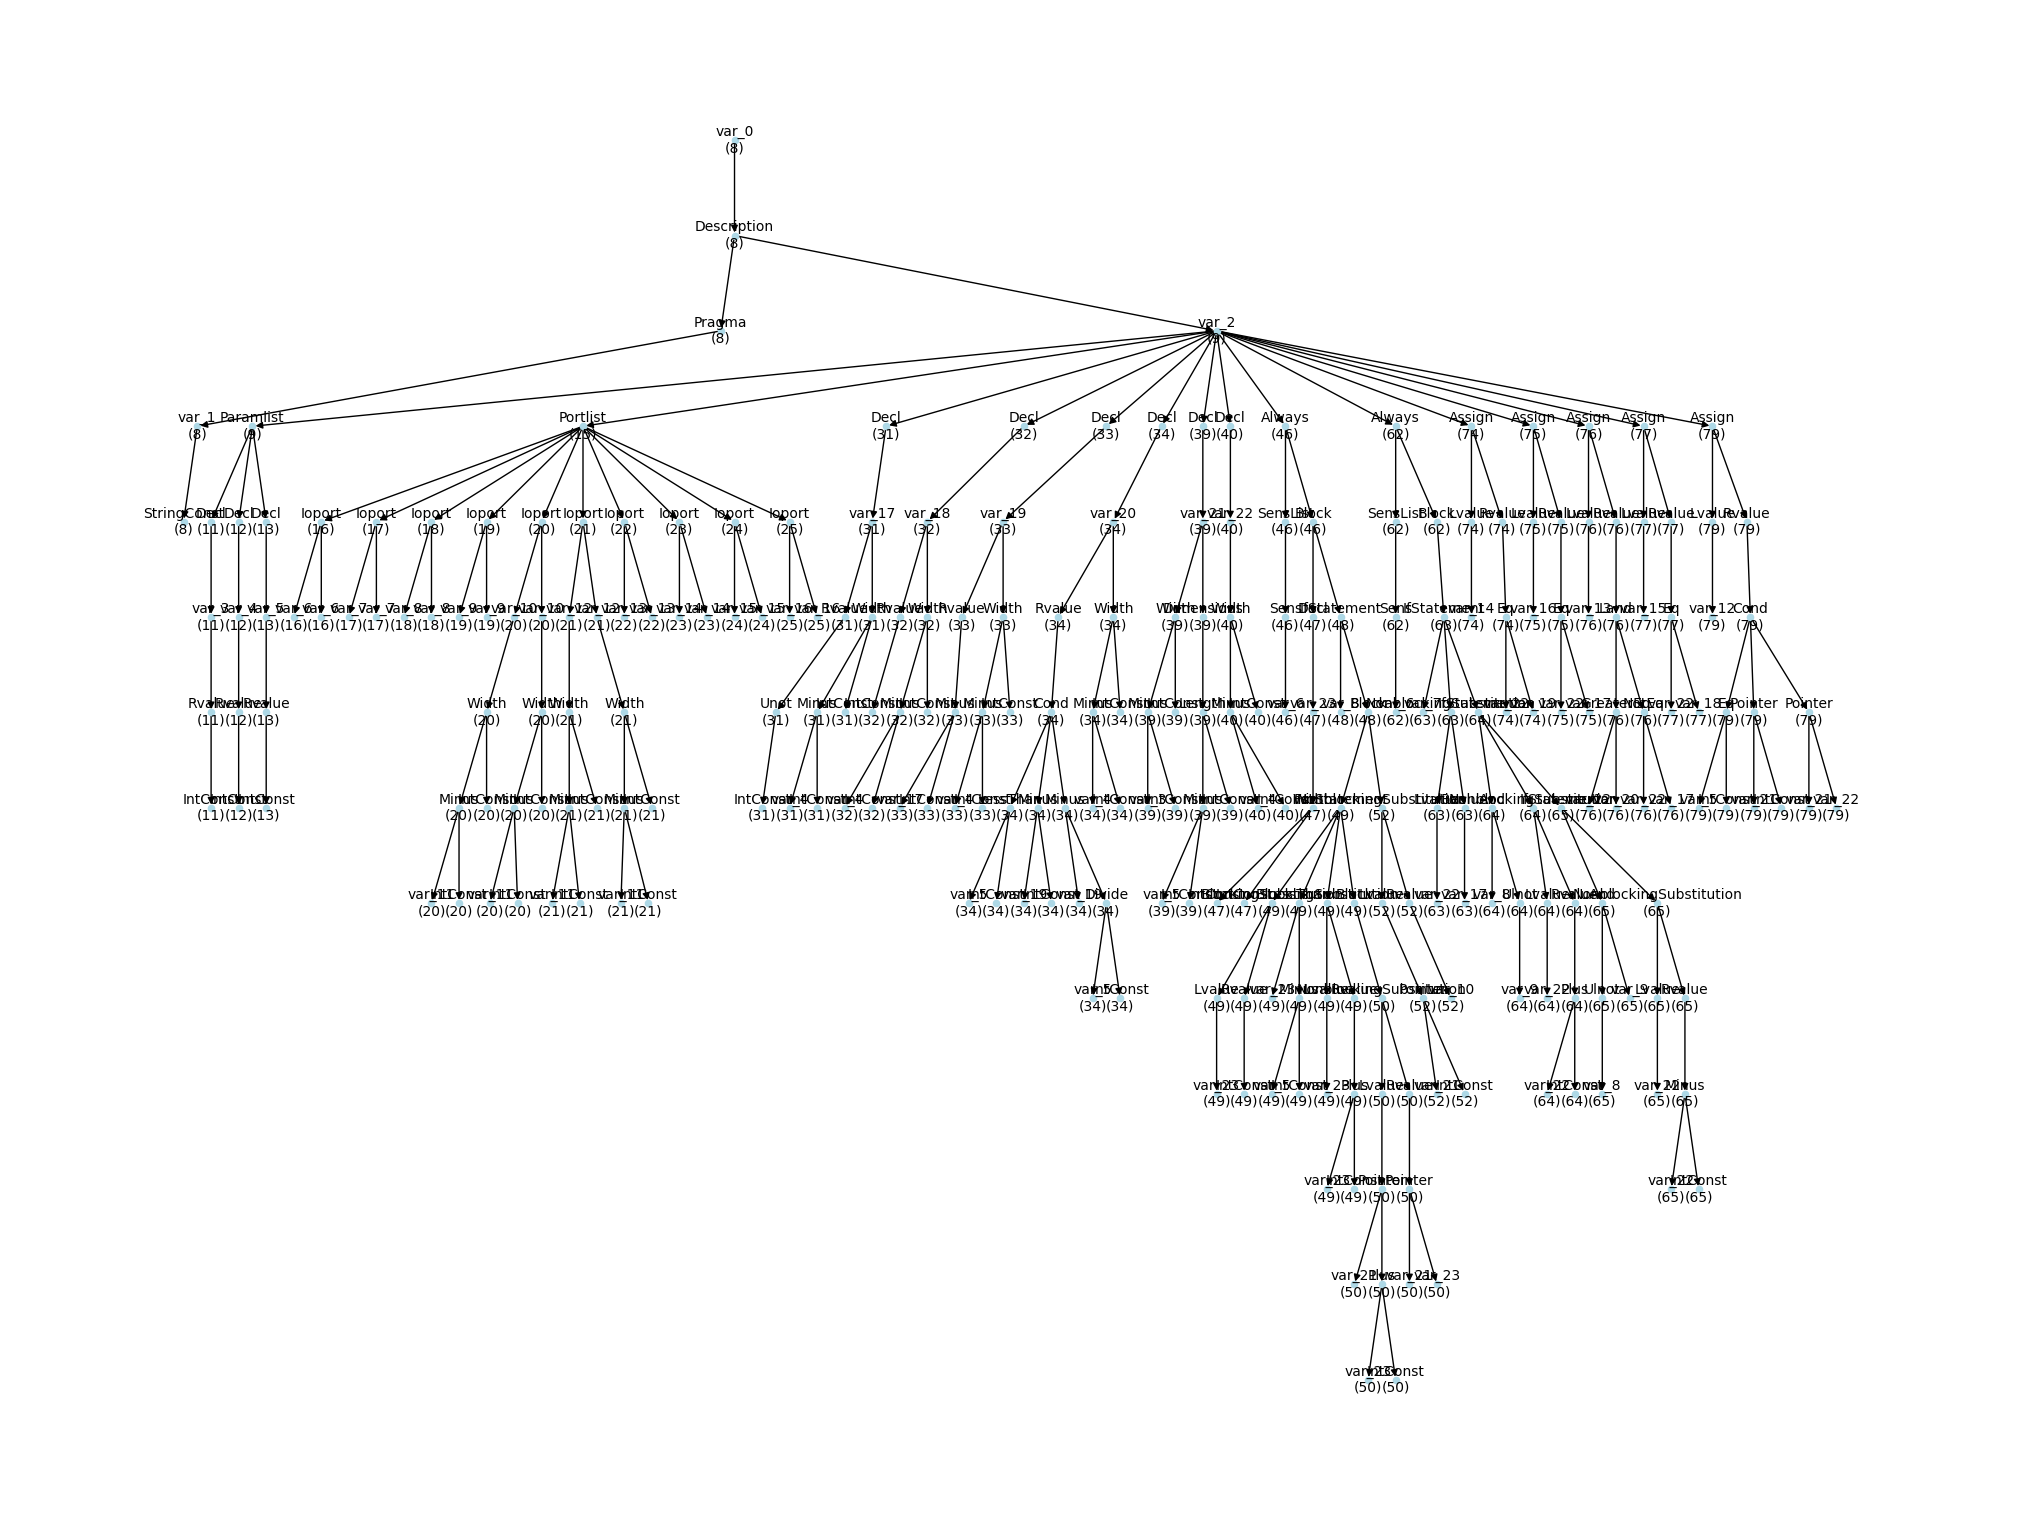

In [81]:
plt.figure(figsize=(20, 15))  # Width, height in inches

# Draw the graph
#pos = nx.spring_layout(G)  # Generate a layout for the graph's nodes
pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw(G, pos, labels=labels, with_labels=True, node_size=20, node_color="lightblue", font_size=10)
plt.show()

In [42]:
from pyverilog.ast_code_generator.codegen import ASTCodeGenerator

# Generate Verilog code from the AST
codegen = ASTCodeGenerator()
verilog_code_from_ast = codegen.visit(ast)

# Print the generated Verilog code
print(verilog_code_from_ast)




module example
(
  input a,
  input b,
  output cgdsfs
);

  assign cgdsfs = a & b;

endmodule


